In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os


In [20]:
# Dataset directory
train_dir = "C:\\Users\\VICTUS\\AI October\\Final Project\\Dataset_Split\\train"
val_dir = "C:\\Users\\VICTUS\\AI October\\Final Project\\Dataset_Split\\val"
test_dir = "C:\\Users\VICTUS\\AI October\\Final Project\\Dataset_Split\\test"

# Model parameters
num_classes = 8  # Specify the number of classes in your dataset
input_shape = (224, 224, 3)  # Input shape expected by DenseNet121

# Training parameters
batch_size = 12
epochs = 50
learning_rate = 0.001


In [21]:
# Data augmentation and generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 2906 images belonging to 8 classes.
Found 620 images belonging to 8 classes.


In [22]:
# Load pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Add GlobalAveragePooling2D layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add Dense layer for classification
predictions = Dense(num_classes, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(lr=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [23]:
 # Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

# Train the model without early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,  # Train for exactly 50 epochs
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, tensorboard]  # Keep other callbacks if needed
)


Epoch 1/50
243/243 [==============================] - ETA: 0s - loss: 1.3733 - accuracy: 0.4642
Epoch 1: val_loss improved from inf to 3.30262, saving model to best_model.h5
243/243 [==============================] - 82s 275ms/step - loss: 1.3733 - accuracy: 0.4642 - val_loss: 3.3026 - val_accuracy: 0.2661
Epoch 2/50
243/243 [==============================] - ETA: 0s - loss: 1.1407 - accuracy: 0.5227
Epoch 2: val_loss improved from 3.30262 to 1.37474, saving model to best_model.h5
243/243 [==============================] - 62s 253ms/step - loss: 1.1407 - accuracy: 0.5227 - val_loss: 1.3747 - val_accuracy: 0.4484
Epoch 3/50
243/243 [==============================] - ETA: 0s - loss: 1.0033 - accuracy: 0.5540
Epoch 3: val_loss did not improve from 1.37474
243/243 [==============================] - 61s 249ms/step - loss: 1.0033 - accuracy: 0.5540 - val_loss: 1.4656 - val_accuracy: 0.4839
Epoch 4/50
243/243 [==============================] - ETA: 0s - loss: 0.9624 - accuracy: 0.5743
Epoch 4

Found 631 images belonging to 8 classes.
53/53 [==============================] - 6s 84ms/step


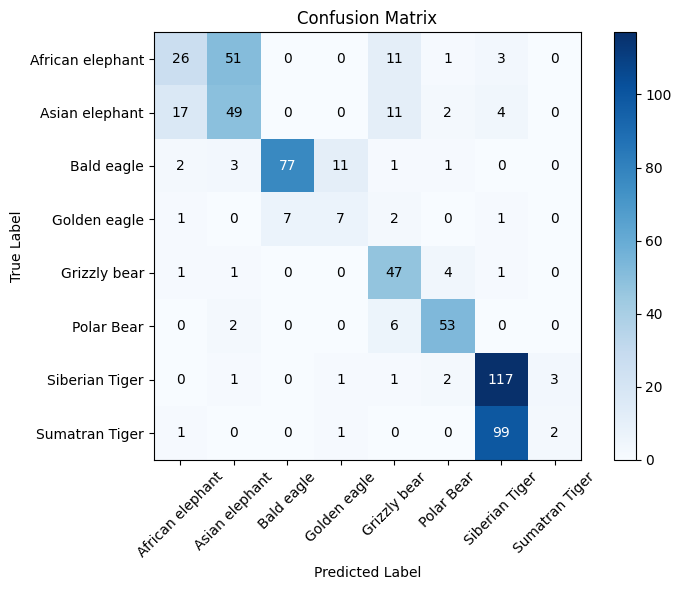

                  precision    recall  f1-score   support

African elephant       0.54      0.28      0.37        92
  Asian elephant       0.46      0.59      0.52        83
      Bald eagle       0.92      0.81      0.86        95
    Golden eagle       0.35      0.39      0.37        18
    Grizzly bear       0.59      0.87      0.71        54
      Polar Bear       0.84      0.87      0.85        61
  Siberian Tiger       0.52      0.94      0.67       125
  Sumatran Tiger       0.40      0.02      0.04       103

        accuracy                           0.60       631
       macro avg       0.58      0.60      0.55       631
    weighted avg       0.59      0.60      0.54       631



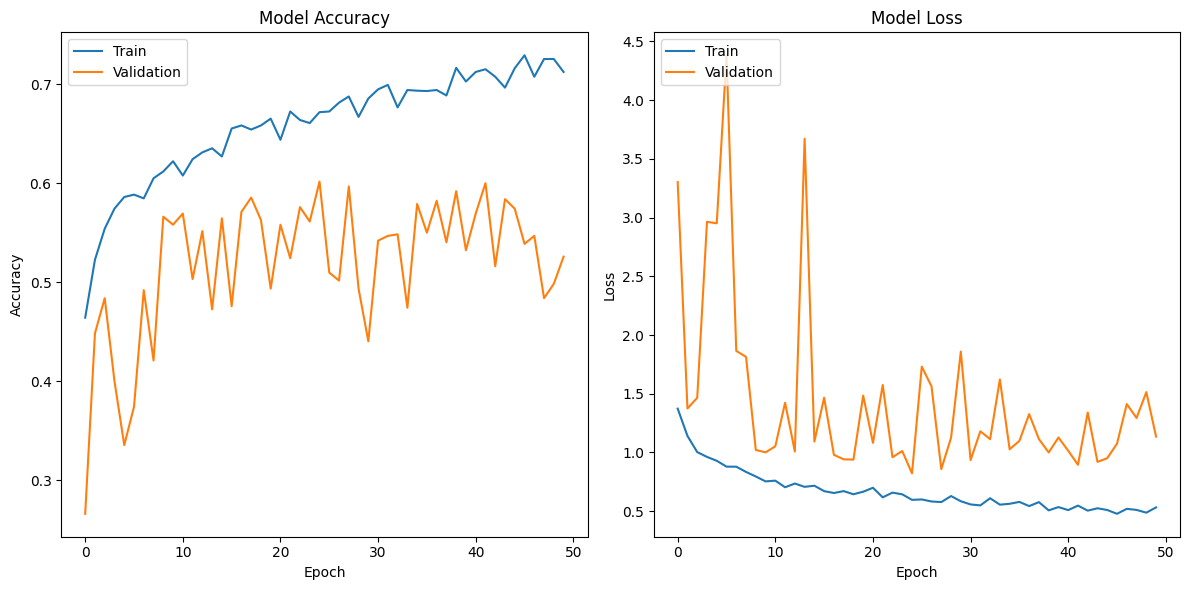

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load best model
model = tf.keras.models.load_model('best_model.h5')

# Evaluate on test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix with numerical annotations
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [25]:
# Assuming `history` object is available after training
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f'Final Training Loss: {final_train_loss:.4f}')
print(f'Final Validation Loss: {final_val_loss:.4f}')


Final Training Loss: 0.5322
Final Validation Loss: 1.1351


In [26]:
# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


53/53 [==============================] - 5s 61ms/step - loss: 0.8596 - accuracy: 0.5990
Test Loss: 0.8596
Test Accuracy: 0.5990


In [27]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121, MobileNetV3Small, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score
import pandas as pd


In [28]:
# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Define paths
base_dir = 'C:\\Users\\VICTUS\\AI October\\Final Project\\Dataset_Split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Data generators without additional preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 2906 images belonging to 8 classes.
Found 620 images belonging to 8 classes.
Found 631 images belonging to 8 classes.


In [29]:
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'model' is your trained DenseNet121 model loaded from 'best_model.h5'
model = tf.keras.models.load_model('best_model.h5')

# Assuming 'test_generator' is your test data generator
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'C:\\Users\\VICTUS\\AI October\\Final Project\\Dataset_Split\\test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluate on test set
start_time = time.time()
loss, accuracy = model.evaluate(test_generator)
end_time = time.time()
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"\nAccuracy: {accuracy:.4f}")

# Classification Report
class_labels = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Training time
training_time = end_time - start_time
print(f"\nTraining Time: {training_time:.2f} seconds")


Found 631 images belonging to 8 classes.
20/20 [==============================] - 8s 233ms/step - loss: 0.8596 - accuracy: 0.5990
Test Loss: 0.8596
Test Accuracy: 0.5990
20/20 [==============================] - 5s 142ms/step

Accuracy: 0.5990

Classification Report:
                  precision    recall  f1-score   support

African elephant       0.54      0.28      0.37        92
  Asian elephant       0.46      0.59      0.52        83
      Bald eagle       0.92      0.81      0.86        95
    Golden eagle       0.35      0.39      0.37        18
    Grizzly bear       0.59      0.87      0.71        54
      Polar Bear       0.84      0.87      0.85        61
  Siberian Tiger       0.52      0.94      0.67       125
  Sumatran Tiger       0.40      0.02      0.04       103

        accuracy                           0.60       631
       macro avg       0.58      0.60      0.55       631
    weighted avg       0.59      0.60      0.54       631


Training Time: 8.30 seconds


Found 2906 images belonging to 8 classes.
Found 620 images belonging to 8 classes.
Found 631 images belonging to 8 classes.
Epoch 1/50
91/91 [==============================] - ETA: 0s - loss: 3.5028 - accuracy: 0.2990
Epoch 1: val_accuracy improved from -inf to 0.37258, saving model to best_densenet121_model.h5
91/91 [==============================] - 48s 468ms/step - loss: 3.5028 - accuracy: 0.2990 - val_loss: 1.6025 - val_accuracy: 0.3726
Epoch 2/50
91/91 [==============================] - ETA: 0s - loss: 1.6940 - accuracy: 0.3699
Epoch 2: val_accuracy improved from 0.37258 to 0.40000, saving model to best_densenet121_model.h5
91/91 [==============================] - 36s 401ms/step - loss: 1.6940 - accuracy: 0.3699 - val_loss: 1.4985 - val_accuracy: 0.4000
Epoch 3/50
91/91 [==============================] - ETA: 0s - loss: 1.5718 - accuracy: 0.3906
Epoch 3: val_accuracy improved from 0.40000 to 0.43065, saving model to best_densenet121_model.h5
91/91 [==============================] 

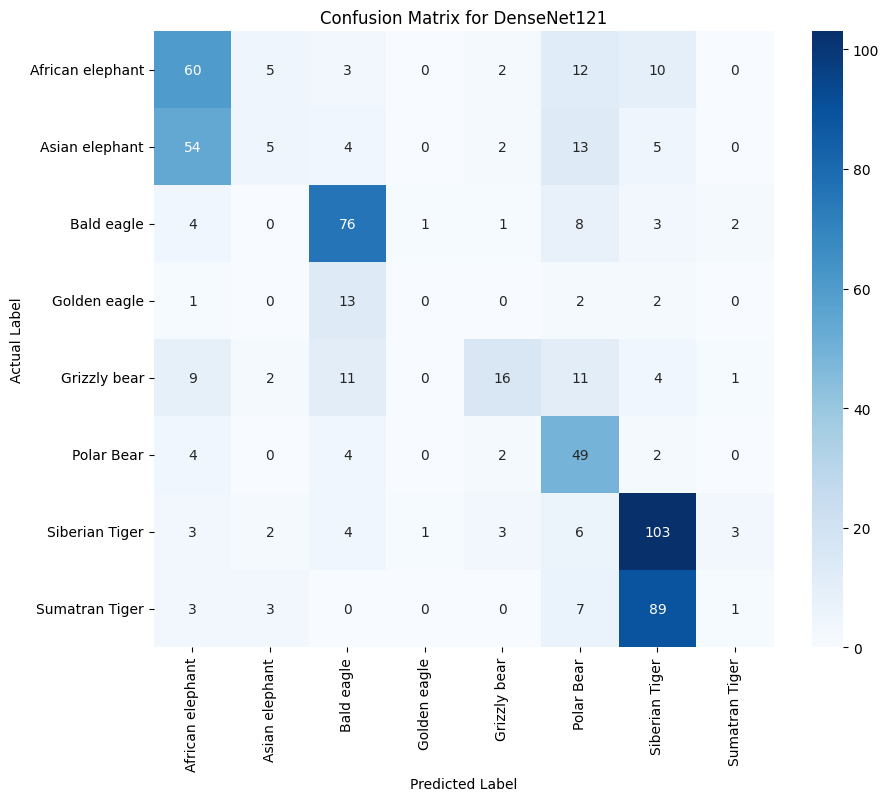

Classification Report for DenseNet121
                  precision    recall  f1-score   support

African elephant       0.43      0.65      0.52        92
  Asian elephant       0.29      0.06      0.10        83
      Bald eagle       0.66      0.80      0.72        95
    Golden eagle       0.00      0.00      0.00        18
    Grizzly bear       0.62      0.30      0.40        54
      Polar Bear       0.45      0.80      0.58        61
  Siberian Tiger       0.47      0.82      0.60       125
  Sumatran Tiger       0.14      0.01      0.02       103

        accuracy                           0.49       631
       macro avg       0.38      0.43      0.37       631
    weighted avg       0.42      0.49      0.41       631



In [30]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score
import matplotlib.pyplot as plt
import time

# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Define paths
base_dir = 'C:\\Users\\VICTUS\\AI October\\Final Project\\Dataset_Split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_densenet121_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
tensorboard = TensorBoard(log_dir='./logs_densenet121', histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, tensorboard, early_stopping]
)
training_time = time.time() - start_time

# Load the best model
model = tf.keras.models.load_model('best_densenet121_model.h5')

# Predict using the loaded model
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Accuracy and mAP calculation
accuracy = accuracy_score(y_true, y_pred_labels)
mean_ap = average_precision_score(tf.keras.utils.to_categorical(y_true), y_pred)

print(f"Accuracy: {accuracy}")
print(f"mAP: {mean_ap}")
print(f"Training Time: {training_time} seconds")

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for DenseNet121')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Print the classification report
print('Classification Report for DenseNet121')
print(classification_report(y_true, y_pred_labels, target_names=test_generator.class_indices.keys()))


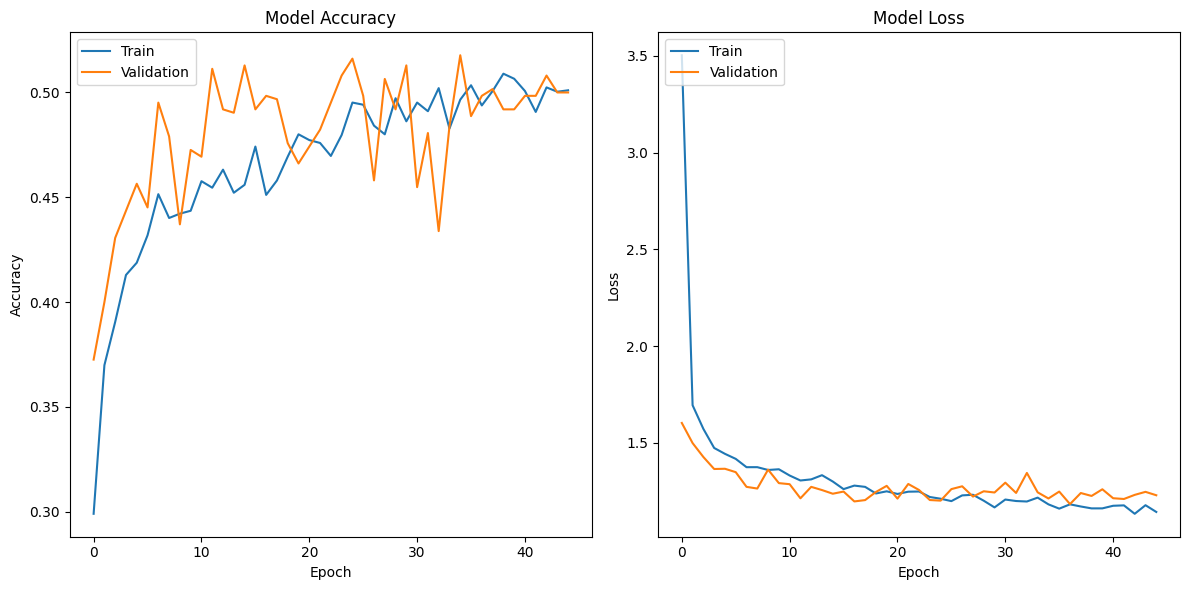

In [31]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [32]:
import tensorflow as tf
from tensorflow.keras.backend import clear_session

clear_session()  # Clears the session to free memory
